# Interpolate 2D Dataset to 1D Slice

SL, LJK

In [2]:
import earthaccess,csv
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.ndimage import median_filter

from scipy.interpolate import LinearNDInterpolator

In [3]:
%pip install haversine
import haversine as hs   
from haversine import Unit

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Set default fontsizes for plots
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [5]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

In [6]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 84


QUEUEING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/84 [00:00<?, ?it/s]

In [7]:
date_requested = '20240508'

ind = 0 
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind)
    ind += 1

23
24


In [8]:
ds1 = xr.open_dataset(edward_paths[23])
ds2 = xr.open_dataset(edward_paths[24])

In [9]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [10]:
ds1_masked = crop_dataset_by_lat_lon(ds1,latmin,latmax,lonmin,lonmax)
ds2_masked = crop_dataset_by_lat_lon(ds2,latmin,latmax,lonmin,lonmax)

## Straight line slice

Linearly interpolating SWOT & PACE data to a standard 2D grid (grid_x, grid_y) & then taking horizontal or vertical slices

In [11]:
xv = np.arange(287, 293, 0.008)
yv = np.arange(33,39, 0.008)
grid_x, grid_y = np.meshgrid(xv, yv)

In [12]:
# Quick velocities: need to change

def quick_velocities(ds, grid_x, grid_y):
    ssh=ds.ssha_karin_2+ds.height_cor_xover
    lats=ds.latitude
    lons=ds.longitude
    grid_ssh = griddata((lons.values.ravel(),lats.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')
    return grid_ssh

In [13]:
grid_ssh1 = quick_velocities(ds1_masked, grid_x, grid_y)
grid_ssh2 = quick_velocities(ds2_masked, grid_x, grid_y)

In [14]:
def compute_geos_current(ssh,lat):
    """
    ssh: (m) Make sure this is first corrected with height_cor_xover from L2 data! 
    lat: degrees N
    """
    
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000,4000 # m i changed it to 4000 to match res? need to double check
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

In [15]:
#Calculate
ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)
ug2,vg2,geos_current2 = compute_geos_current(grid_ssh2,grid_y)

In [16]:
tspan = ("2024-05-08", "2024-05-08")
#bbox = (-58, 37.5, -52, 41) #howie
bbox = (-73, 35, -70, 37) #edward
# bbox=(-61, 34, -59, 39) #patrick
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)
paths = earthaccess.open(results) #'streaming' data

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
datatree = open_datatree(paths[0])
datatree
dataset = xr.merge(datatree.to_dict().values())
dataset
chl_ds = dataset.set_coords(("longitude", "latitude"))
# chl_ds = xr.open_dataset(paths[0]) # should rename this with file extention .nc
lon_chl = chl_ds.variables['longitude'] 
lat_chl = chl_ds.variables['latitude'] 
chl = chl_ds.variables['chlor_a']

In [18]:
dataset = xr.open_dataset('/home/jovyan/GO-SWACE/moana_dataset_merged.nc')
lon = dataset['longitude'] 
lat = dataset['latitude'] 

# dataset = dataset.assign_coords(lat = lat, lon = lon) #Open data with xarray for 'slice plots'
# dataset = dataset.set_coords(("longitude", "latitude"))
pico = dataset["picoeuk_moana"] 
pro = dataset['prococcus_moana']
syn = dataset['syncoccus_moana'] 

In [19]:
pro_grid = griddata((lon.values.ravel()+360,lat.values.ravel()), pro.values.ravel(), (grid_x, grid_y), method='linear')
pico_grid = griddata((lon.values.ravel()+360,lat.values.ravel()), pico.values.ravel(), (grid_x, grid_y), method='linear')
syn_grid = griddata((lon.values.ravel()+360,lat.values.ravel()), syn.values.ravel(), (grid_x, grid_y), method='linear')
chl_grid = griddata((lon_chl.values.ravel()+360,lat_chl.values.ravel()), chl.values.ravel(), (grid_x, grid_y), method='linear')

<Figure size 640x480 with 0 Axes>

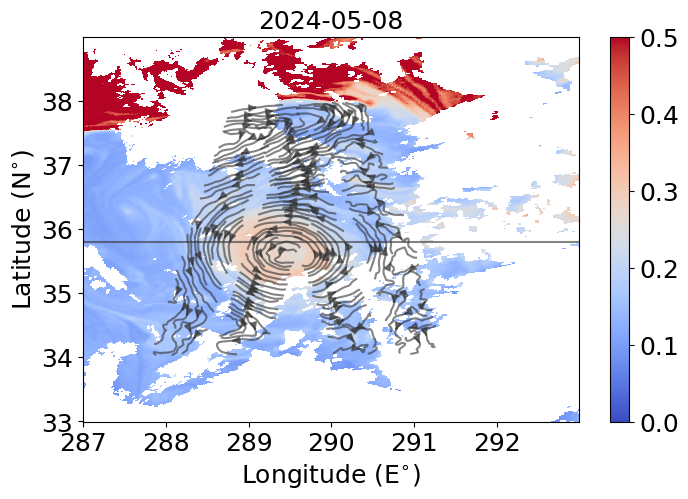

In [20]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,chl_grid,cmap='coolwarm',vmin=0,vmax=0.5)
cbar = plt.colorbar(plot,ax=ax)
plt.streamplot(grid_x,grid_y,ug1,vg1, density = 4, color = (0.2,0.2,0.2,0.6))
plt.streamplot(grid_x,grid_y,ug2,vg2, density = 4, color = (0.2,0.2,0.2,0.6))
plt.plot(grid_x[350,:],grid_y[350,:], color = (0.2,0.2,0.2,0.6)) #MOANA slice

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

In [21]:
#Select slice along SWOT
grid_x[200,:].max()

292.99199999998604

In [22]:
grid_x[350,0]
grid_y[350,0]

35.800000000000935

In [23]:
loc1=(grid_y[350,0],grid_x[350,0]-360) #"origin"

alongtrack=[]

for idx in np.arange(0,len(grid_x[350,:])):
    loc2=(grid_y[350,idx],grid_x[350,idx]-360) 
    result=hs.haversine(loc1,loc2,unit=Unit.KILOMETERS)
    alongtrack=np.append(alongtrack,result)

In [24]:
#define a line of latitudes and longitudes and extract data along that line. or sample to same grid

In [25]:
np.shape(alongtrack)

(750,)

In [26]:
np.shape(pico_grid[350,:])

(750,)

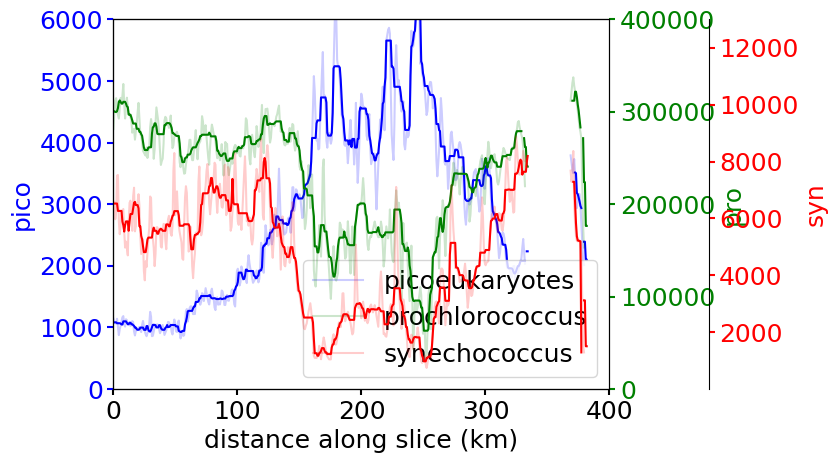

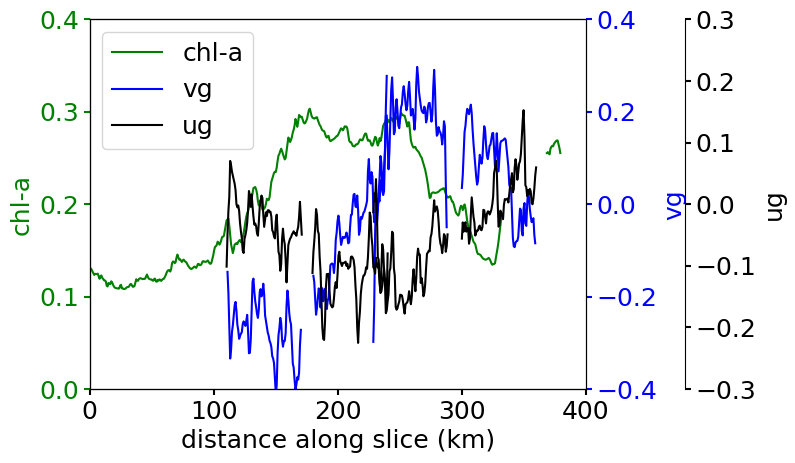

In [27]:
fig, ax = plt.subplots()
# fig, (ax, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,5))

fig.subplots_adjust(right=0.9)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot(alongtrack,pico_grid[350,:], "b-", label="picoeukaryotes",alpha=0.2)
ax.plot(alongtrack,median_filter(pico_grid[350,:],10), "b-", label="picoeukaryotes")
p2, = twin1.plot(alongtrack,pro_grid[350,:], "g-", label="prochlorococcus",alpha=0.2)
twin1.plot(alongtrack,median_filter(pro_grid[350,:],10), "g-", label="prochlorococcus")
p3, = twin2.plot(alongtrack,syn_grid[350,:], "r-", label="synechococcus",alpha=0.2)
twin2.plot(alongtrack,median_filter(syn_grid[350,:],10), "r-", label="synechococcus")

ax.set_xlim(0,400)
ax.set_ylim(0,6000)
twin1.set_ylim(0, 400000)
twin1.set_xlim(0,400)
twin2.set_ylim(1, 13000)
twin2.set_xlim(0,400)

ax.set_xlabel("distance along slice (km)")
ax.set_ylabel("pico")
twin1.set_ylabel("pro")
twin2.set_ylabel("syn")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()

fig, ax = plt.subplots()
# fig, (ax, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,5))

fig.subplots_adjust(right=0.9)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot(alongtrack,chl_grid[350,:], "g-", label="chl-a")
# ax.plot(alongtrack,median_filter(chl_grid[350,:],10), "g-", label="chl-a")

p2, = twin1.plot(alongtrack,vg1[350,:], "b-", label="vg")#,alpha=0.2)
# twin1.plot(alongtrack,median_filter(vg1[350,:],20), "b-", label="vg")
twin1.plot(alongtrack,vg2[350,:], "b-", label="vg")
# twin1.plot(alongtrack,median_filter(vg2[350,:],20), "b-", label="vg")

p3, = twin2.plot(alongtrack,ug1[350,:], "k-", label="ug")#,alpha=0.2)
# twin2.plot(alongtrack,median_filter(ug1[350,:],20), "k-", label="ug")
twin2.plot(alongtrack,ug2[350,:], "k-", label="ug")
# twin2.plot(alongtrack,median_filter(ug2[350,:],20), "k-", label="ug")


ax.set_xlim(0,400)
ax.set_ylim(0,0.4)
twin1.set_ylim(-0.4,0.4)
twin1.set_xlim(0,400)
twin2.set_ylim(-0.3,0.3)
twin2.set_xlim(0,400)

ax.set_xlabel("distance along slice (km)")
twin2.set_ylabel("ug")
twin1.set_ylabel("vg")
ax.set_ylabel("chl-a")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()

## SWOT-swath oriented slice

Not interpolating to a standard grid. Getting a line along the SWOT swaths, and then interpolating the equivalent "slice" through SWOT and PACE.

In [28]:
ds1_masked

<xarray.Dataset> Size: 13MB
Dimensions:                                (num_lines: 241, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 133kB ...
    longitude                              (num_lines, num_pixels) float64 133kB ...
    latitude_nadir                         (num_lines) float64 2kB 38.12 ... ...
    longitude_nadir                        (num_lines) float64 2kB 289.6 ... ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines, num_pixels) datetime64[ns] 133kB ...
    time_tai                               (num_lines, num_pixels) datetime64[ns] 133kB ...
    ssh_karin                              (num_lines, num_pixels) float64 133kB ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 133kB ...
    ssh_karin_uncert                       (num_lines, num_pixels) float64 133kB ...
    ssha_karin                             (num_lines, num_pixels) float64 133kB ...
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 67kB ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 67kB ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 67kB ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 67kB ...
    volumetric_correlation                 (num_lines, num_pixels) float64 133kB ...
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 133kB ...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-05-10T22:44:22Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       48.9302559080739
    ssha_variance:                                 0.06752108217511198
    references:                                    V1.2.1
    equator_longitude:                             -63.30

Separate the SWOT swaths using `cross_track_distance`: negative is left swath, positive is right (relative to orbit direction maybe? because here its switched)

In [29]:
cross_track_distance = ds1_masked.cross_track_distance

# Create masks for left and right swaths
left_swath_mask = cross_track_distance < 0
right_swath_mask = cross_track_distance > 0

# Separate data 
left_ds1 = ds1_masked.where(left_swath_mask, drop=True)
right_ds1 = ds1_masked.where(right_swath_mask, drop=True)

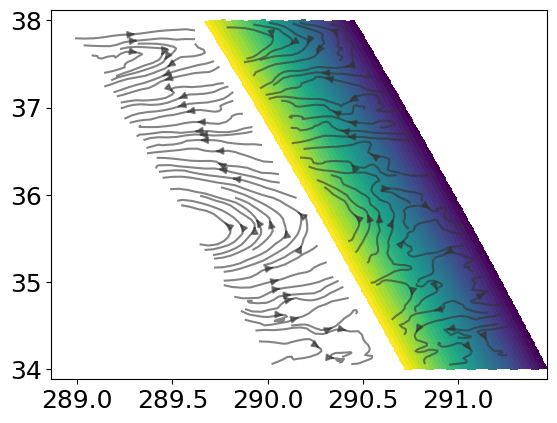

In [30]:
fig, ax = plt.subplots()

ax.pcolormesh(left_ds1.longitude,left_ds1.latitude,left_ds1.cross_track_distance)
ax.streamplot(grid_x,grid_y,ug1,vg1, density = 4, color = (0.2,0.2,0.2,0.6))

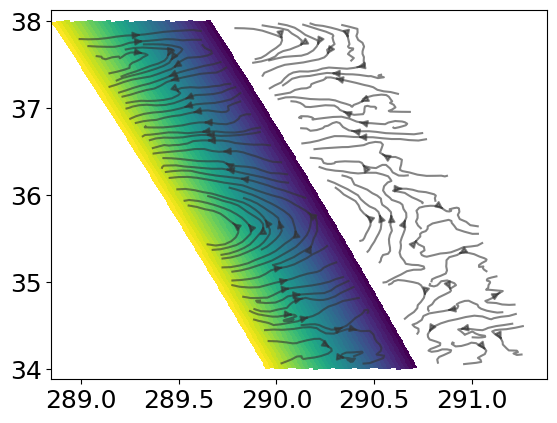

In [31]:
fig, ax = plt.subplots()

ax.pcolormesh(right_ds1.longitude,right_ds1.latitude,right_ds1.cross_track_distance)
ax.streamplot(grid_x,grid_y,ug1,vg1, density = 4, color = (0.2,0.2,0.2,0.6))

Draw a line through the middle of the swath

In [32]:
mean_lats = np.nanmean(right_ds1.latitude,axis=1)
mean_lons = np.nanmean(right_ds1.longitude,axis=1)

y1,y2 = mean_lats[0],mean_lats[-1]
x1,x2 = mean_lons[0],mean_lons[-1]

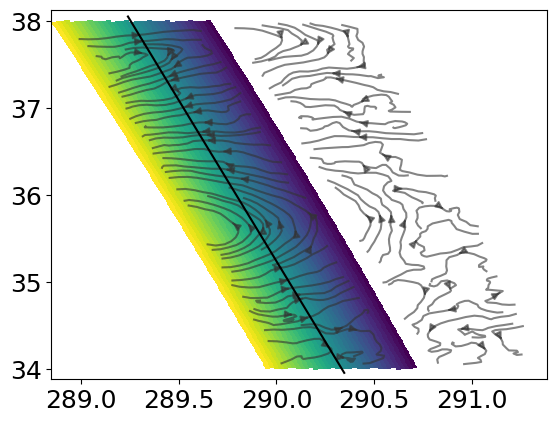

In [33]:
fig, ax = plt.subplots()

ax.pcolormesh(right_ds1.longitude,right_ds1.latitude,right_ds1.cross_track_distance)
ax.streamplot(grid_x,grid_y,ug1,vg1, density = 4, color = (0.2,0.2,0.2,0.6))
ax.plot([x1,x2],[y1,y2],c='k')

Interpolate the SWOT data along the line

In [34]:
def line_interp(x1,x2,y1,y2,num_points=1000):
    """
    Use line eq. to get more points along the line from points (x1,y1) and (x2,y2)
    """
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - (m*x1)
    
    def line(x):
        return m * x + b
    
    x_values = np.linspace(x1, x2, num_points)
    y_values = line(x_values)
    line_points = np.array([x_values, y_values]).T
    return line_points

In [35]:
line_points = line_interp(x1,x2,y1,y2,1000)
interpolator = LinearNDInterpolator(list(zip(np.ravel(right_ds1.longitude),np.ravel(right_ds1.latitude))), np.ravel(right_ds1.ssha_karin_2+right_ds1.height_cor_xover)) 
line_ssha = interpolator(line_points)

Text(0.5, 0, 'SSHA Through Slice')

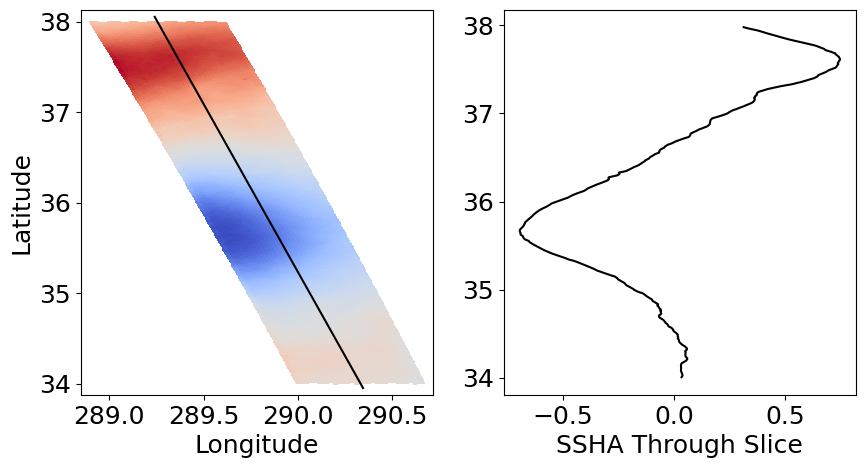

In [36]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].pcolormesh(right_ds1.longitude,right_ds1.latitude,right_ds1.ssha_karin_2+right_ds1.height_cor_xover,cmap='coolwarm')
ax[0].plot([x1,x2],[y1,y2],c='k')
ax[1].plot(line_ssha,line_points[:,1],c='k')

ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('SSHA Through Slice')

## Along-Swath Slices in SWOT and MOANA

Pulling together steps above into a cleaner function

In [37]:
def get_center_line_endpoints(ds):
    """
    Returns endpoints for each swath: [left_x1,left_x2,left_y1,left_y2],[right_x1,right_x2,right_y1,right_y2]
    """
    
    cross_track_distance = ds.cross_track_distance

    # Create masks for left and right swaths
    left_swath_mask = cross_track_distance < 0
    right_swath_mask = cross_track_distance > 0
    
    # Separate data 
    left_ds = ds.where(left_swath_mask, drop=True)
    right_ds = ds.where(right_swath_mask, drop=True)

    # Get endpoints from center line for each swath
    endpoints = []
    for side in [left_ds,right_ds]:
        mean_lats = np.nanmean(side.latitude,axis=1)
        mean_lons = np.nanmean(side.longitude,axis=1)
        
        y1,y2 = mean_lats[0],mean_lats[-1]
        x1,x2 = mean_lons[0],mean_lons[-1]
        endpoints.append([x1,x2,y1,y2])
        
    return endpoints[0],endpoints[1]

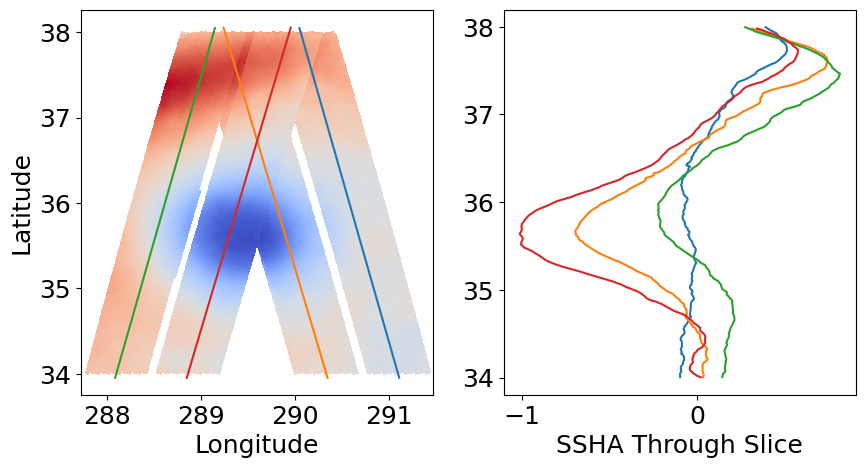

In [38]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('SSHA Through Slice')

for ds in [ds1_masked,ds2_masked]:
    ax[0].pcolormesh(ds.longitude,ds.latitude,ds.ssha_karin_2+ds.height_cor_xover,cmap='coolwarm') #plot ssha
    
    interpolator = LinearNDInterpolator(list(zip(np.ravel(ds.longitude),np.ravel(ds.latitude))),np.ravel(ds.ssha_karin_2+ds.height_cor_xover))
    left_endpoints,right_endpoints = get_center_line_endpoints(ds) 

    # get the center line from each side of the swath
    for endpoints in [left_endpoints,right_endpoints]:

        # interpolate the geostrophic velocity along the line
        line_points = line_interp(endpoints[0],endpoints[1],endpoints[2],endpoints[3],1000)
        line_geos = interpolator(line_points)

        ax[0].plot([endpoints[0],endpoints[1]],[endpoints[2],endpoints[3]])
        ax[1].plot(line_geos,line_points[:,1])

In [39]:
def crop_moana_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin) & (ds.longitude <= lonmax)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [40]:
moana_ds = xr.open_dataset('moana_dataset_merged.nc')
moana_masked = crop_moana_dataset_by_lat_lon(moana_ds,latmin,latmax,lonmin,lonmax)
moana_masked

<xarray.Dataset> Size: 6MB
Dimensions:          (number_of_lines: 441, pixels_per_line: 252)
Coordinates:
    longitude        (number_of_lines, pixels_per_line) float32 445kB -72.8 ....
    latitude         (number_of_lines, pixels_per_line) float32 445kB 33.17 ....
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    picoeuk_moana    (number_of_lines, pixels_per_line) float32 445kB nan ......
    prococcus_moana  (number_of_lines, pixels_per_line) float32 445kB nan ......
    syncoccus_moana  (number_of_lines, pixels_per_line) float32 445kB nan ......
    rhos_465         (number_of_lines, pixels_per_line) float32 445kB nan ......
    rhos_555         (number_of_lines, pixels_per_line) float32 445kB nan ......
    rhos_645         (number_of_lines, pixels_per_line) float32 445kB nan ......
    poc              (number_of_lines, pixels_per_line) float32 445kB nan ......
    chlor_a          (number_of_lines, pixels_per_line) float32 445kB nan ......
    l2_flags         (number_of_lines, pixels_per_line) float64 889kB nan ......
    tilt             (number_of_lines, pixels_per_line) float32 445kB nan ......

In [41]:
lon = moana_masked.variables['longitude']
lat = moana_masked.variables['latitude']
pro = moana_masked.variables['prococcus_moana']
pico = moana_masked.variables['picoeuk_moana']
syn = moana_masked.variables['syncoccus_moana']

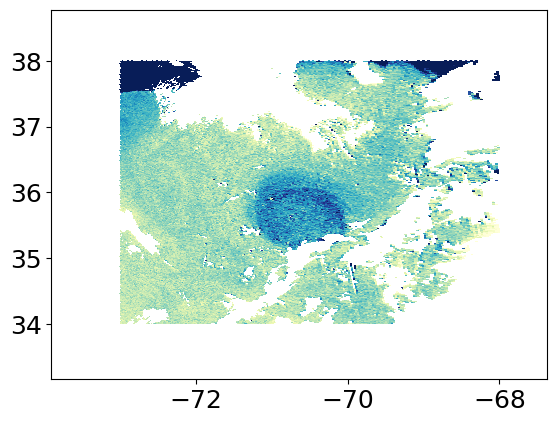

In [42]:
fig = plt.figure()
ax = plt.axes()
plot=ax.pcolormesh(lon,lat,pro,cmap='YlGnBu_r',vmax=400000)

Only difference with MOANA data is the negative to positive longitude conversion

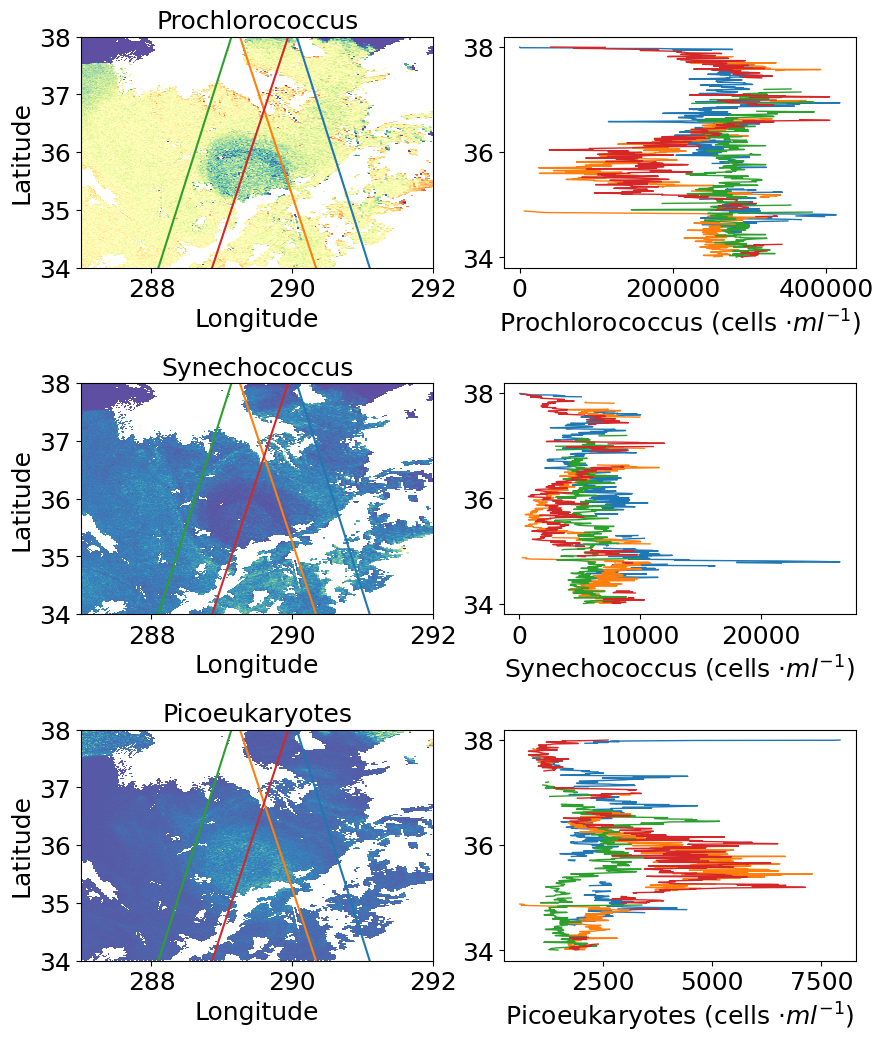

In [43]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
plt.subplots_adjust(hspace=0.5)

i = 0
names = ['Prochlorococcus','Synechococcus','Picoeukaryotes']
for plankton in [pro,syn,pico]:
    
    ax[i,0].pcolormesh(lon+360,lat,plankton,cmap='Spectral_r') #plot the plankton concentration

    for ds in [ds1_masked,ds2_masked]: # interate through the SWOT datasets            
        left_endpoints,right_endpoints = get_center_line_endpoints(ds) 

        #nan_mask = ~np.isnan(np.ravel(plankton))
        #interpolator = LinearNDInterpolator(list(zip(np.ravel(lon)[nan_mask]+360,np.ravel(lat)[nan_mask])),np.ravel(plankton)[nan_mask])
        interpolator = LinearNDInterpolator(list(zip(np.ravel(lon)+360,np.ravel(lat))),np.ravel(plankton))

        # get the center line from each side of the swath
        for endpoints in [left_endpoints,right_endpoints]:
    
            # interpolate the geostrophic velocity along the line
            line_points = line_interp(endpoints[0],endpoints[1],endpoints[2],endpoints[3],1000)
            line_geos = interpolator(line_points)
            
            ax[i,0].plot([endpoints[0],endpoints[1]],[endpoints[2],endpoints[3]])
            ax[i,1].plot(line_geos,line_points[:,1],linewidth=1)

    # plot params
    ax[i,0].set_xlim([lonmin+360,lonmax+360])
    ax[i,0].set_ylim([latmin,latmax])
    ax[i,0].set_ylabel('Latitude')
    ax[i,0].set_xlabel('Longitude')
    ax[i,0].set_title(names[i])
    ax[i,1].set_xlabel('%s (cells $ \cdot ml^{-1}$)'%(names[i]))
    
    i += 1

## Add u_along, du_along/dx, EKE: IN PROGRESS -Slang

In [85]:
i = 0
for ds in [ds1_masked,ds2_masked]:
    if i==0:
        U=ug1
        V=vg1
        num=1
    elif i==1:
        U=ug2
        V=vg2
        num=2
    
    interpolatorU = LinearNDInterpolator(list(zip(np.ravel(grid_x),np.ravel(grid_y))),np.ravel(U))
    interpolatorV = LinearNDInterpolator(list(zip(np.ravel(grid_x),np.ravel(grid_y))),np.ravel(V))

    left_endpoints,right_endpoints = get_center_line_endpoints(ds) 

        # get the center line from each side of the swath
    for endpoints in [left_endpoints,right_endpoints]:
    
        # interpolate the geostrophic velocity along the line
        line_points = line_interp(endpoints[0],endpoints[1],endpoints[2],endpoints[3],1000)
        UU = interpolatorU(line_points)
        VV = interpolatorV(line_points)
        
        if endpoints==left_endpoints:
            exec("ug" + str(num) + "a = UU")
            exec("vg" + str(num) + "a = VV")
        elif endpoints==right_endpoints:
            exec("ug" + str(num) + "b = UU")
            exec("vg" + str(num) + "b = VV")

    i += 1

In [86]:
EKE1=( (ug1a**2)+(vg1a**2) ) / 2
EKE2=( (ug1b**2)+(vg1b**2) ) / 2
EKE3=( (ug2a**2)+(vg2a**2) ) / 2
EKE4=( (ug2b**2)+(vg2b**2) ) / 2

Redundant

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
plt.subplots_adjust(hspace=0.5)

i = 0
names = ['Prochlorococcus','Synechococcus','Picoeukaryotes']
for plankton in [pro,syn,pico]:
    
    ax[i,0].pcolormesh(lon+360,lat,plankton,cmap='Spectral_r') #plot the plankton concentration

    for ds in [ds1_masked,ds2_masked]: # interate through the SWOT datasets            
        left_endpoints,right_endpoints = get_center_line_endpoints(ds) 

        #nan_mask = ~np.isnan(np.ravel(plankton))
        #interpolator = LinearNDInterpolator(list(zip(np.ravel(lon)[nan_mask]+360,np.ravel(lat)[nan_mask])),np.ravel(plankton)[nan_mask])
        interpolator = LinearNDInterpolator(list(zip(np.ravel(lon)+360,np.ravel(lat))),np.ravel(plankton))

        # get the center line from each side of the swath
        for endpoints in [left_endpoints,right_endpoints]:
    
            # interpolate the geostrophic velocity along the line
            line_points = line_interp(endpoints[0],endpoints[1],endpoints[2],endpoints[3],1000)
            line_geos = interpolator(line_points)
            
            ax[i,0].plot([endpoints[0],endpoints[1]],[endpoints[2],endpoints[3]])
            ax[i,1].plot(line_geos,line_points[:,1],linewidth=1)

    # plot params
    ax[i,0].set_xlim([lonmin+360,lonmax+360])
    ax[i,0].set_ylim([latmin,latmax])
    ax[i,0].set_ylabel('Latitude')
    ax[i,0].set_xlabel('Longitude')
    ax[i,0].set_title(names[i])
    ax[i,1].set_xlabel('%s (cells $ \cdot ml^{-1}$)'%(names[i]))
    
    i += 1

Calculate angle to horizontal. 

Pieces of code adapted from https://github.com/rsignell-usgs/RPSstuff/blob/master/RPSstuff/princax.m

In [ ]:
f=x1;
g=y1;

x1(f<0)=[];
y1(f<0)=[];

x=x1;
y=y1;
w = x+sqrt(-1)*y;

% use only the good (finite) points
ind=find(isfinite(w));
wr=w;
w=w(ind);

% find covariance matrix
cv=cov([real(w(:)) imag(w(:))]); 

% find direction of maximum variance
theta=0.5*atan2(2.*cv(2,1),(cv(1,1)-cv(2,2)) );

% find major and minor axis amplitudes 

term1=(cv(1,1)+cv(2,2));
term2=sqrt((cv(1,1)-cv(2,2)).^2 + 4.*cv(2,1).^2);
maj=sqrt(.5*(term1+term2));
min=sqrt(.5*(term1-term2));

% rotate into principal ellipse orientation

wr(ind)=w.*exp(-i*theta);
theta_deg=theta*180./pi;

xr = real(wr);
yr = imag(wr);
xrot=xr;
yrot=yr;

x_regrid = 0:256:7e4; 
y_regrid = 0:256:10e4;

theta=deg2rad(theta_deg);

b=(u + (1i*v)).* exp(-1i*theta); %angle relative to horizontal. rotate CW

%og
u_along = real(b);
u_across = imag(b);

u_along(f<0)=[];
u_across(f<0)=[];

## Add biology gradients